In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d
import copy

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_pxpypze(px, py, pz, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'px': px, 'py': py, 'pz': pz, 'energy': energy})
def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

Creating six-panel comparison plot...

Processing ggHH (event index: 0)...
Rate for hhvsboth > 0.9: 0.8458
Total events passing all selections: 342849
Selected event index: 0
Peak + background fit successful
Found 20 potential secondary peaks, strongest at (195.0, 105.0) with value 0.0050
Secondary peak fit successful
Fitting successful for ggHH
Peak1 position: (118.8, 120.7)

Processing ZZ (event index: 1)...
Rate for hhvsboth > 0.9: 0.2533
Total events passing all selections: 2197
Selected event index: 1
Peak + background fit successful
Found 24 potential secondary peaks, strongest at (175.0, 65.0) with value 0.0065
Secondary peak fit successful
Fitting successful for ZZ
Peak1 position: (119.9, 165.5)

Processing ZH (event index: 2)...
Rate for hhvsboth > 0.9: 0.4869
Total events passing all selections: 1467
Selected event index: 2
Peak + background fit successful
Found 9 potential secondary peaks, strongest at (145.0, 95.0) with value 0.0041
Secondary peak fit successful
Fitting suc

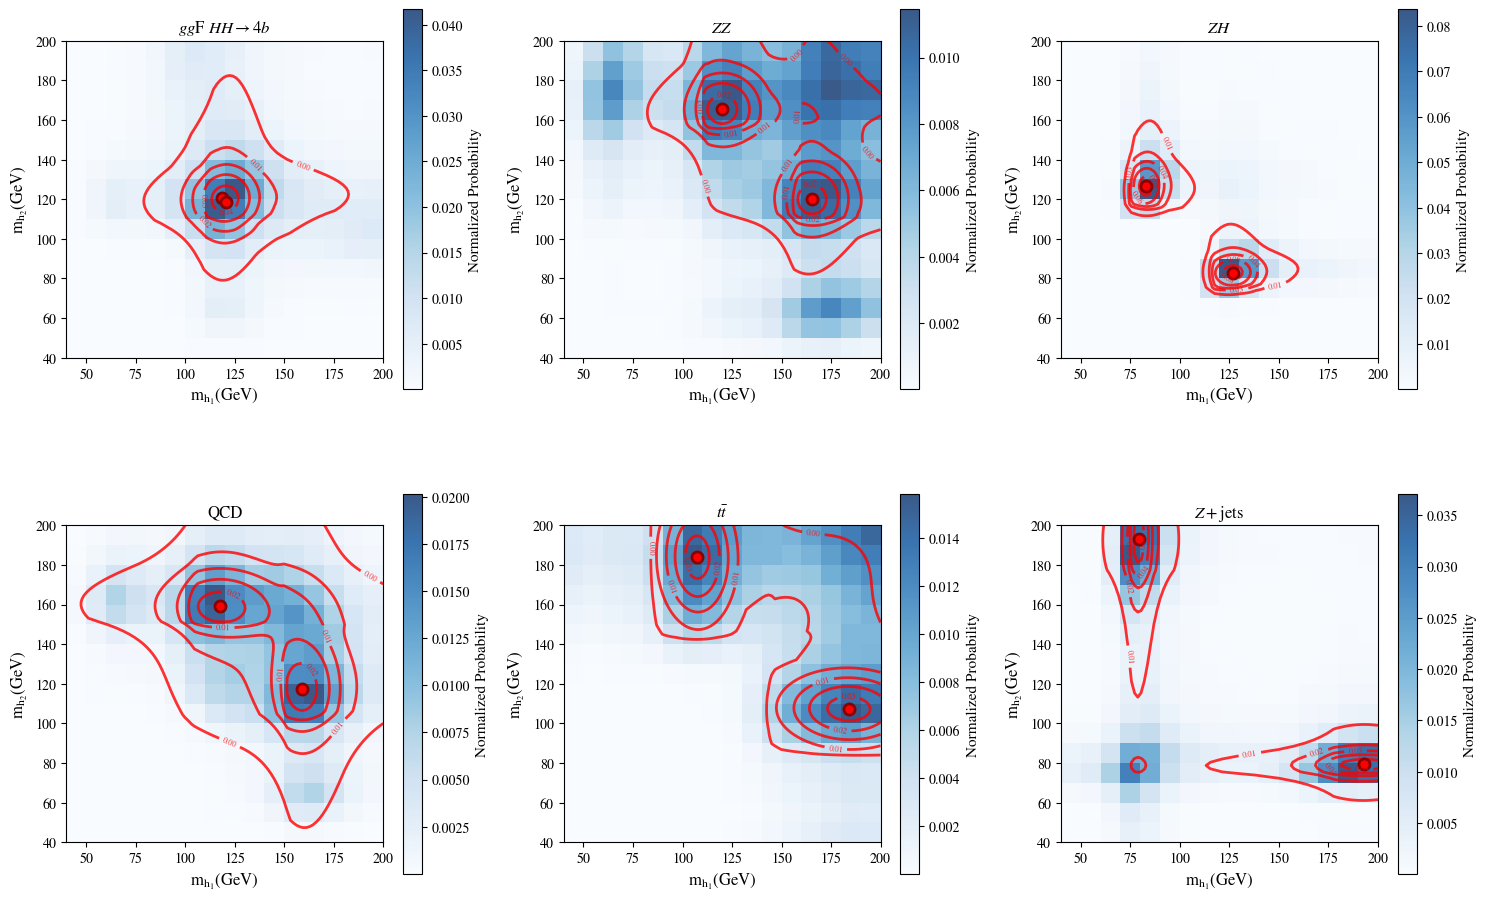

Done!


In [3]:
import sys
import time
from scipy.optimize import curve_fit
from scipy import ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable

def double_crystal_ball_1d(x, mean, sigma, alpha_low, n_low, alpha_high, n_high):
    """
    Correct implementation of 1D Double Crystal Ball function with continuity
    """
    t = (x - mean) / sigma
    result = np.zeros_like(t, dtype=float)
    
    # Calculate correct B parameters to ensure continuity
    B_low = np.exp(0.5 * alpha_low**2 / n_low) - alpha_low
    B_high = np.exp(0.5 * alpha_high**2 / n_high) - alpha_high
    
    # Central Gaussian region
    mask_central = ((-alpha_low <= t) & (t <= alpha_high))
    result[mask_central] = np.exp(-0.5 * t[mask_central]**2)
    
    # Low tail (t < -alpha_low)
    mask_low = (t < -alpha_low)
    if np.any(mask_low):
        # Gaussian value at t = -alpha_low
        gaussian_at_switch = np.exp(-0.5 * alpha_low**2)
        # Power law function, ensuring continuity at switch point
        result[mask_low] = gaussian_at_switch * \
                          (B_low + alpha_low)**n_low * \
                          (B_low - t[mask_low])**(-n_low)
    
    # High tail (t > alpha_high)  
    mask_high = (t > alpha_high)
    if np.any(mask_high):
        # Gaussian value at t = alpha_high
        gaussian_at_switch = np.exp(-0.5 * alpha_high**2)
        # Power law function, ensuring continuity at switch point
        result[mask_high] = gaussian_at_switch * \
                           (B_high + alpha_high)**n_high * \
                           (B_high + t[mask_high])**(-n_high)
    
    return result


def bivariate_double_crystal_ball(xy_mesh, amplitude, x_mean, y_mean, x_sigma, y_sigma, theta, 
                                 alpha_low_x, n_low_x, alpha_high_x, n_high_x,
                                 alpha_low_y, n_low_y, alpha_high_y, n_high_y):
    """
    2D Double Crystal Ball function with rotation and asymmetric tails
    """
    x, y = xy_mesh
    
    # Rotate coordinates
    x_rot = (x - x_mean) * np.cos(theta) + (y - y_mean) * np.sin(theta)
    y_rot = -(x - x_mean) * np.sin(theta) + (y - y_mean) * np.cos(theta)
    
    # Apply 1D Double Crystal Ball in each rotated dimension
    x_component = double_crystal_ball_1d(x_rot, 0, x_sigma, alpha_low_x, n_low_x, alpha_high_x, n_high_x)
    y_component = double_crystal_ball_1d(y_rot, 0, y_sigma, alpha_low_y, n_low_y, alpha_high_y, n_high_y)
    
    # Combine components (product of distributions)
    return amplitude * x_component * y_component

def background_2d_new(xy_mesh, amp, x_center, y_center, x_slope, y_slope, x_log, y_log):
    """
    New flexible 2D background function with arbitrary slope directions
    """
    x, y = xy_mesh
    
    # Use linear + logarithmic combination with center as reference
    x_component = 1.0 + x_slope * (x - x_center) + x_log * np.log(x/x_center)
    y_component = 1.0 + y_slope * (y - y_center) + y_log * np.log(y/y_center)
    
    # Ensure non-negative
    result = amp * np.maximum(x_component * y_component, 1e-10)
    return result

def symmetric_background_pair_new(xy_mesh, amp, x_center, y_center, x_slope, y_slope, x_log, y_log):
    """
    New symmetric pair of 2D background functions
    Creates f(x,y) + f(y,x) which is symmetric about the diagonal y=x
    """
    x, y = xy_mesh
    
    # Original background: f(x,y)
    bg1 = background_2d_new((x, y), amp, x_center, y_center, x_slope, y_slope, x_log, y_log)
    
    # Mirrored background: f(y,x) - swap coordinates and parameters appropriately
    bg2 = background_2d_new((y, x), amp, y_center, x_center, y_slope, x_slope, y_log, x_log)
    
    return bg1 + bg2


def single_peak_with_mirror(xy, *params):
    """
    Single DCB peak with its mirror
    """
    amp, x_mean, y_mean, x_sigma, y_sigma, theta, alpha_low, n_low, alpha_high, n_high = params
    x, y = xy
    
    # Main peak
    peak = bivariate_double_crystal_ball(
        (x, y), amp, x_mean, y_mean, x_sigma, y_sigma, theta,
        alpha_low, n_low, alpha_high, n_high, alpha_low, n_low, alpha_high, n_high
    )
    
    # Mirror peak
    mirror = bivariate_double_crystal_ball(
        (x, y), amp, y_mean, x_mean, y_sigma, x_sigma, -theta,
        alpha_low, n_low, alpha_high, n_high, alpha_low, n_low, alpha_high, n_high
    )
    
    return peak + mirror

def peak_plus_background_with_mirror(xy, *params):
    """
    Combined model: DCB peak pair + symmetric background pair (new version)
    """
    # Split parameters
    # DCB parameters: amp, x_mean, y_mean, x_sigma, y_sigma, theta, alpha_low, n_low, alpha_high, n_high (10 params)
    # Background parameters: bg_amp, x_center, y_center, x_slope, y_slope, x_log, y_log (7 params)
    
    dcb_params = params[:10]
    bg_params = params[10:]
    
    # DCB component
    dcb_component = single_peak_with_mirror(xy, *dcb_params)
    
    # Background component (new version)
    bg_component = symmetric_background_pair_new(xy, *bg_params)
    
    return dcb_component + bg_component

def extract_full_histogram_data(scores, bins):
    """
    Extract data for the full symmetric histogram from triangular scores
    """
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    n_bins = len(bin_centers)
    
    # Create empty histogram
    H = np.zeros((n_bins, n_bins))
    
    # Fill triangular region
    idx = 0
    for i in range(n_bins):
        for j in range(i, n_bins):
            H[i, j] = scores[idx]
            idx += 1
    
    # Create symmetric histogram
    H_sym = (H + H.T) / 2
    
    return H_sym, bin_centers

def fit_symmetric_four_dcb_staged(scores, bins):
    """
    Staged fitting strategy: first fit peak+background, then fit secondary peak
    Uses new flexible background function
    """
    # Extract full symmetric histogram
    H_sym, bin_centers = extract_full_histogram_data(scores, bins)
    
    # Normalize the histogram
    H_sym_norm = H_sym / np.sum(H_sym)
    
    # Create mesh grid for fitting
    X, Y = np.meshgrid(bin_centers, bin_centers)
    x_flat = X.flatten()
    y_flat = Y.flatten()
    z_flat = H_sym_norm.flatten()
    
    # Find the maximum value point (main peak)
    max_idx = np.argmax(H_sym_norm)
    max_i, max_j = np.unravel_index(max_idx, H_sym_norm.shape)
    max_x, max_y = bin_centers[max_i], bin_centers[max_j]
    max_val = H_sym_norm[max_i, max_j]
    
    # Ensure peak is in the upper triangle region (x ≤ y)
    if max_x > max_y:
        max_x, max_y = max_y, max_x
    
    # Calculate center of the data range for background reference
    x_center = (bin_centers[0] + bin_centers[-1]) / 2
    y_center = (bin_centers[0] + bin_centers[-1]) / 2
    
    # Stage 1: Fit peak + background model
    
    # Initial parameters for peak + background (new version)
    # DCB parameters: amp, x_mean, y_mean, x_sigma, y_sigma, theta, alpha_low, n_low, alpha_high, n_high
    # Background parameters: bg_amp, x_center, y_center, x_slope, y_slope, x_log, y_log
    initial_guess_peak_bg = [
        max_val * 0.7, max_x, max_y, 15.0, 15.0, 0.0,  # DCB parameters
        1.5, 3.0, 1.5, 3.0,                            # DCB tail parameters
        max_val * 0.3, x_center, y_center, 0.0, 0.0, 0.0, 0.0  # Background parameters (new)
    ]
    
    # Parameter bounds (updated for new background function)
    lower_bounds_peak_bg = [
        0.0, 0.0, 0.0, 2.5, 2.5, -np.pi/4,  # DCB bounds
        0.5, 1.5, 0.5, 1.5,                  # DCB tail bounds
        0.0, 40.0, 40.0, -0.01, -0.01, -0.5, -0.5  # Background bounds (new)
    ]
    
    upper_bounds_peak_bg = [
        np.inf, np.inf, np.inf, 50.0, 50.0, np.pi/4,  # DCB bounds (reduced sigma limit)
        3.0, 10.0, 3.0, 10.0,                         # DCB tail bounds
        np.inf, 200.0, 200.0, 0.01, 0.01, 0.5, 0.5   # Background bounds (new)
    ]
    
    bounds_peak_bg = (lower_bounds_peak_bg, upper_bounds_peak_bg)
    
    try:
        # Fit peak + background
        params_peak_bg, cov_peak_bg = curve_fit(
            peak_plus_background_with_mirror, 
            (x_flat, y_flat), 
            z_flat, 
            p0=initial_guess_peak_bg,
            bounds=bounds_peak_bg,
            maxfev=15000,
            method='trf'
        )
        
        peak1_success = True
        print("Peak + background fit successful")
    except (RuntimeError, ValueError) as e:
        peak1_success = False
        params_peak_bg = np.array(initial_guess_peak_bg)
        print(f"Peak + background fit failed: {e}")
    
    # Calculate peak + background model
    peak_bg_model_flat = peak_plus_background_with_mirror((x_flat, y_flat), *params_peak_bg)
    peak_bg_model = peak_bg_model_flat.reshape(X.shape)
    
    # Calculate residual (original data minus peak + background model)
    residual_flat = z_flat - peak_bg_model_flat
    residual = residual_flat.reshape(X.shape)
    
    # Extract parameters from peak + background fit
    dcb_params = params_peak_bg[:10]
    bg_params = params_peak_bg[10:]
    
    amp1, x_mean1, y_mean1, x_sigma1, y_sigma1, theta1, alpha_low1, n_low1, alpha_high1, n_high1 = dcb_params
    
    # Create mask for finding secondary peak
    mask = np.ones_like(residual, dtype=bool)
    mask_radius = max(15, 2.0 * max(x_sigma1, y_sigma1))
    
    # Mask area around main peak and its mirror
    for i in range(len(bin_centers)):
        for j in range(len(bin_centers)):
            # Calculate distance to main peak and its mirror
            dist1 = np.sqrt((bin_centers[i] - x_mean1)**2 + (bin_centers[j] - y_mean1)**2)
            dist2 = np.sqrt((bin_centers[i] - y_mean1)**2 + (bin_centers[j] - x_mean1)**2)
            if dist1 < mask_radius or dist2 < mask_radius:
                mask[i, j] = False
    
    # Apply mask to residual
    masked_residual = residual.copy()
    masked_residual[~mask] = 0
    
    # Find secondary peaks
    neighborhood_size = 2
    local_max = ndimage.maximum_filter(masked_residual, size=neighborhood_size)
    threshold = max(0.02 * max_val, 0.01 * np.max(masked_residual))
    local_max_mask = (masked_residual == local_max) & (masked_residual > threshold)
    
    # Find coordinates of local maxima
    local_max_coords = np.where(local_max_mask)
    
    if len(local_max_coords[0]) > 0:
        # Get all local maxima with their values
        candidates = []
        for idx in range(len(local_max_coords[0])):
            i, j = local_max_coords[0][idx], local_max_coords[1][idx]
            x_pos, y_pos = bin_centers[i], bin_centers[j]
            val = masked_residual[i, j]
            candidates.append((x_pos, y_pos, val, i, j))
        
        # Sort by value (strongest first)
        candidates.sort(key=lambda x: x[2], reverse=True)
        
        # Take the strongest candidate
        max2_x, max2_y, max2_val, max2_i, max2_j = candidates[0]
        secondary_peak_found = True
        
        print(f"Found {len(candidates)} potential secondary peaks, strongest at ({max2_x:.1f}, {max2_y:.1f}) with value {max2_val:.4f}")
        
    else:
        max2_x, max2_y = 500.0, 500.0
        max2_val = 0.0
        secondary_peak_found = False
        print("No secondary peak found in residual")
    
    # Stage 2: Fit secondary peak if found
    if secondary_peak_found:
        lower_bounds_peak2 = [
            0.0, 0.0, 0.0, 1.0, 1.0, -np.pi/2,
            0.3, 1.0, 0.3, 1.0
        ]
        
        upper_bounds_peak2 = [
            np.inf, np.inf, np.inf, 300.0, 300.0, np.pi/2,
            5.0, 15.0, 5.0, 15.0
        ]
        
        bounds_peak2 = (lower_bounds_peak2, upper_bounds_peak2)
        
        # Try multiple strategies for better fitting
        best_fit = None
        best_residual_sum = np.inf
        
        sigma_candidates = [(5.0, 5.0), (10.0, 10.0), (15.0, 15.0), (20.0, 20.0)]
        
        for x_sig, y_sig in sigma_candidates:
            initial_guess_peak2 = [
                max2_val * 0.8, max2_x, max2_y, x_sig, y_sig, 0.0,
                1.5, 3.0, 1.5, 3.0
            ]
            
            try:
                params, _ = curve_fit(
                    single_peak_with_mirror, 
                    (x_flat, y_flat), 
                    residual_flat, 
                    p0=initial_guess_peak2,
                    bounds=bounds_peak2,
                    maxfev=8000,
                    method='trf'
                )
                
                model = single_peak_with_mirror((x_flat, y_flat), *params)
                current_residual = np.sum((residual_flat - model)**2)
                
                if current_residual < best_residual_sum:
                    best_residual_sum = current_residual
                    best_fit = params
                    
            except (RuntimeError, ValueError):
                continue
        
        if best_fit is not None:
            params_peak2 = best_fit
            peak2_success = True
            print("Secondary peak fit successful")
        else:
            params_peak2 = np.array([
                0.0, 500.0, 500.0, 15.0, 15.0, 0.0,
                1.5, 3.0, 1.5, 3.0
            ])
            peak2_success = False
            print("Secondary peak fitting failed")
            
    else:
        params_peak2 = np.array([
            0.0, 500.0, 500.0, 15.0, 15.0, 0.0,
            1.5, 3.0, 1.5, 3.0
        ])
        peak2_success = False
    
    # Check peak1 and peak2 positions, swap if needed
    amp1, x_mean1, y_mean1, x_sigma1, y_sigma1, theta1, alpha_low1, n_low1, alpha_high1, n_high1 = dcb_params
    amp2, x_mean2, y_mean2, x_sigma2, y_sigma2, theta2, alpha_low2, n_low2, alpha_high2, n_high2 = params_peak2
    
    # Check if peak1 is in valid range
    peak1_in_range = (40 <= x_mean1 <= 200) and (40 <= y_mean1 <= 200)
    peak2_in_range = (40 <= x_mean2 <= 200) and (40 <= y_mean2 <= 200)
    
    peaks_swapped = False
    
    if not peak1_in_range and peak2_in_range and peak2_success:
        print(f"Peak1 at ({x_mean1:.1f}, {y_mean1:.1f}) is out of range, Peak2 at ({x_mean2:.1f}, {y_mean2:.1f}) is in range. Swapping peaks.")
        
        # Swap peak parameters
        dcb_params, params_peak2 = params_peak2, dcb_params
        amp1, x_mean1, y_mean1, x_sigma1, y_sigma1, theta1, alpha_low1, n_low1, alpha_high1, n_high1 = dcb_params
        amp2, x_mean2, y_mean2, x_sigma2, y_sigma2, theta2, alpha_low2, n_low2, alpha_high2, n_high2 = params_peak2
        peaks_swapped = True
        
        # Fine-tune peak1 amplitude and background parameters with new peak1
        def peak1_plus_background_adjustable(xy, amp1_new, bg_amp_new, bg_x_center_new, bg_y_center_new, 
                                           bg_x_slope_new, bg_y_slope_new, bg_x_log_new, bg_y_log_new):
            peak1_params_adjustable = [amp1_new] + list(dcb_params[1:])
            peak_component = single_peak_with_mirror(xy, *peak1_params_adjustable)
            bg_component = symmetric_background_pair_new(xy, bg_amp_new, bg_x_center_new, bg_y_center_new,
                                                        bg_x_slope_new, bg_y_slope_new, bg_x_log_new, bg_y_log_new)
            return peak_component + bg_component
        
        finetune_initial = [amp1] + list(bg_params)
        
        finetune_lower = [
            0.0,  # amp1 lower bound
            0.0, 40.0, 40.0, -0.01, -0.01, -0.5, -0.5  # background bounds
        ]
        
        finetune_upper = [
            np.inf,  # amp1 upper bound  
            np.inf, 200.0, 200.0, 0.01, 0.01, 0.5, 0.5  # background bounds
        ]
        
        finetune_bounds = (finetune_lower, finetune_upper)
        
        try:
            optimized_params, _ = curve_fit(
                peak1_plus_background_adjustable,
                (x_flat, y_flat),
                z_flat,
                p0=finetune_initial,
                bounds=finetune_bounds,
                maxfev=5000,
                method='trf'
            )
            
            amp1 = optimized_params[0]
            bg_params = optimized_params[1:]
            dcb_params[0] = amp1
            
            print("Peak1 amplitude and background fine-tuning after peak swap successful")
            
        except (RuntimeError, ValueError) as e:
            print(f"Peak1 amplitude and background fine-tuning failed: {e}, keeping original parameters")
        
        # Recalculate residual for second peak2 fitting
        updated_params_peak_bg = list(dcb_params) + list(bg_params)
        peak_bg_model_flat = peak_plus_background_with_mirror((x_flat, y_flat), *updated_params_peak_bg)
        residual_flat = z_flat - peak_bg_model_flat
        residual = residual_flat.reshape(X.shape)
        
        # Recreate mask for second peak2 fitting
        mask = np.ones_like(residual, dtype=bool)
        mask_radius = max(15, 2.0 * max(x_sigma1, y_sigma1))
        
        for i in range(len(bin_centers)):
            for j in range(len(bin_centers)):
                dist1 = np.sqrt((bin_centers[i] - x_mean1)**2 + (bin_centers[j] - y_mean1)**2)
                dist2 = np.sqrt((bin_centers[i] - y_mean1)**2 + (bin_centers[j] - x_mean1)**2)
                if dist1 < mask_radius or dist2 < mask_radius:
                    mask[i, j] = False
        
        masked_residual = residual.copy()
        masked_residual[~mask] = 0
        
        # Re-find second peak
        local_max = ndimage.maximum_filter(masked_residual, size=neighborhood_size)
        threshold = max(0.02 * max_val, 0.01 * np.max(masked_residual))
        local_max_mask = (masked_residual == local_max) & (masked_residual > threshold)
        local_max_coords = np.where(local_max_mask)
        
        if len(local_max_coords[0]) > 0:
            candidates = []
            for idx in range(len(local_max_coords[0])):
                i, j = local_max_coords[0][idx], local_max_coords[1][idx]
                x_pos, y_pos = bin_centers[i], bin_centers[j]
                val = masked_residual[i, j]
                candidates.append((x_pos, y_pos, val, i, j))
            
            candidates.sort(key=lambda x: x[2], reverse=True)
            max2_x, max2_y, max2_val, max2_i, max2_j = candidates[0]
            
            # Re-fit peak2
            best_fit = None
            best_residual_sum = np.inf
            
            for x_sig, y_sig in sigma_candidates:
                initial_guess_peak2 = [
                    max2_val * 0.8, max2_x, max2_y, x_sig, y_sig, 0.0,
                    1.5, 3.0, 1.5, 3.0
                ]
                
                try:
                    params, _ = curve_fit(
                        single_peak_with_mirror, 
                        (x_flat, y_flat), 
                        residual_flat, 
                        p0=initial_guess_peak2,
                        bounds=bounds_peak2,
                        maxfev=8000,
                        method='trf'
                    )
                    
                    model = single_peak_with_mirror((x_flat, y_flat), *params)
                    current_residual = np.sum((residual_flat - model)**2)
                    
                    if current_residual < best_residual_sum:
                        best_residual_sum = current_residual
                        best_fit = params
                        
                except (RuntimeError, ValueError):
                    continue
            
            if best_fit is not None:
                params_peak2 = best_fit
                peak2_success = True
                print("Secondary peak re-fitting after swap successful")
            else:
                params_peak2 = np.array([
                    0.0, 500.0, 500.0, 15.0, 15.0, 0.0,
                    1.5, 3.0, 1.5, 3.0
                ])
                peak2_success = False
                print("Secondary peak re-fitting after swap failed")
        else:
            params_peak2 = np.array([
                0.0, 500.0, 500.0, 15.0, 15.0, 0.0,
                1.5, 3.0, 1.5, 3.0
            ])
            peak2_success = False
            print("No secondary peak found after swap")
    
    # Re-parse parameters (possibly swapped)
    amp1, x_mean1, y_mean1, x_sigma1, y_sigma1, theta1, alpha_low1, n_low1, alpha_high1, n_high1 = dcb_params
    amp2, x_mean2, y_mean2, x_sigma2, y_sigma2, theta2, alpha_low2, n_low2, alpha_high2, n_high2 = params_peak2
    
    # Normalize amplitudes
    if peak2_success and x_mean2 < 400:
        total_amp = np.sum(single_peak_with_mirror((x_flat, y_flat), *dcb_params)) + \
                   np.sum(single_peak_with_mirror((x_flat, y_flat), *params_peak2))
        scale_factor = 1.0 / total_amp if total_amp > 0 else 1.0
        amp1 *= scale_factor
        amp2 *= scale_factor
        bg_params[0] *= scale_factor
    else:
        total_amp = np.sum(single_peak_with_mirror((x_flat, y_flat), *dcb_params))
        scale_factor = 1.0 / total_amp if total_amp > 0 else 1.0
        amp1 *= scale_factor
        amp2 = 0.0
        bg_params[0] *= scale_factor
    
    # Update parameter arrays
    dcb_params[0] = amp1
    params_peak2[0] = amp2
    
    # Combine all parameters including background
    params = np.array([
        amp1, x_mean1, y_mean1, x_sigma1, y_sigma1, theta1,
        alpha_low1, n_low1, alpha_high1, n_high1,
        amp2, x_mean2, y_mean2, x_sigma2, y_sigma2, theta2,
        alpha_low2, n_low2, alpha_high2, n_high2
    ] + list(bg_params))
    
    # Calculate metrics
    if x_mean2 < 400 and y_mean2 < 400:
        distance = np.sqrt((x_mean1 - x_mean2)**2 + (y_mean1 - y_mean2)**2)
        amplitude_ratio = amp1 / amp2 if amp2 > 0 else float('inf')
    else:
        distance = float('inf')
        amplitude_ratio = float('inf')
    
    dominant_peak = amplitude_ratio > 10.0
    
    # Create metrics dictionary
    metrics = {
        'distance': distance,
        'amplitude_ratio': amplitude_ratio,
        'dominant_peak': dominant_peak,
        'peak1_success': peak1_success,
        'peak2_success': peak2_success,
        'secondary_peak_found': secondary_peak_found,
        'valid_secondary': x_mean2 < 400 and y_mean2 < 400,
        'background_params': bg_params,
        'peaks_swapped': peaks_swapped
    }
    
    fit_success = peak1_success
    
    return params, fit_success, metrics

def fit_symmetric_four_dcb(scores, bins):
    """
    Main fitting function
    """
    params, fit_success, metrics = fit_symmetric_four_dcb_staged(scores, bins)
    
    return params, fit_success, metrics

def load_and_process_events(file_path, cut_value=0.8, event_index=0):
    """
    Load single event from ROOT file and apply selections
    """
    try:
        pred_data_tmp = uproot.lazy(file_path)
        pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
        
        scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
        _scaledprobs = np.ones((len(pred_data), 136))
        
        for j in range(136):
            scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
            _scaledprobs[:,j] = pred_data[f'score_{j}']
        
        scaledprobs_maxidx = ak.from_numpy(np.argmax(_scaledprobs[:, :136], axis=1))
        
        pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
        pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])
        
        # Apply score cut
        score_hhvsboth = pred_data['score_hh4bvsboth']
        score_cut_mask = (score_hhvsboth > cut_value)
        
        final_data = pred_data[score_cut_mask]
        final_scaledprobs = _scaledprobs[score_cut_mask]
        
        print(f"Rate for hhvsboth > {cut_value}: {np.sum(score_cut_mask)/len(score_hhvsboth):.4f}")
        print(f"Total events passing all selections: {np.sum(score_cut_mask)}")
        
        if len(final_data) == 0:
            print("No events pass the score cut")
            return None, None
        
        # Check if requested event index exists
        if event_index >= len(final_data):
            print(f"Event index {event_index} not available, using index 0")
            event_index = 0
        
        # Return single event
        selected_score = final_scaledprobs[event_index]
        
        print(f"Selected event index: {event_index}")
        
        return selected_score, final_data[event_index]
        
    except Exception as e:
        print(f"Error processing ROOT file: {e}")
        import traceback
        traceback.print_exc()
        return None, None


def create_2d_histogram_from_scores(scores, bins):
    """
    Create 2D histogram from 1D scores array
    """
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    n_bins = len(bin_centers)
    
    # Create empty histogram
    H = np.zeros((n_bins, n_bins))
    
    # Fill the histogram using triangular indexing
    idx = 0
    for i in range(n_bins):
        for j in range(i, n_bins):
            H[i, j] = scores[idx]
            idx += 1
    
    # Make symmetric
    H = (H + H.T) / 2
    H = H / np.sum(H)
    
    return H, bin_centers

def plot_event_with_peak1_contours(scores, bins, fit_params, event_idx, ax, title):
    """
    Plot 2D histogram with Peak1 contours on given axis (modified for subplot)
    """
    # Create 2D histogram
    H, bin_centers = create_2d_histogram_from_scores(scores, bins)
    
    # Extract Peak1 parameters
    amp1, x_mean1, y_mean1, x_sigma1, y_sigma1, theta1 = fit_params[:6]
    alpha_low1, n_low1, alpha_high1, n_high1 = fit_params[6:10]
    
    # Create histogram edges for plotting
    _, xedges, yedges = np.histogram2d([], [], bins=[bins, bins])
    
    # Plot the 2D histogram
    mesh = ax.pcolormesh(xedges, yedges, H.T, shading='flat', cmap='Blues', alpha=0.8)
    
    # Create mesh grid for contour plotting
    x_contour = np.linspace(40, 200, 100)
    y_contour = np.linspace(40, 200, 100)
    X_contour, Y_contour = np.meshgrid(x_contour, y_contour)
    
    # Calculate Peak1 component for contours
    peak1_main = bivariate_double_crystal_ball(
        (X_contour, Y_contour), amp1, x_mean1, y_mean1, x_sigma1, y_sigma1, theta1,
        alpha_low1, n_low1, alpha_high1, n_high1, alpha_low1, n_low1, alpha_high1, n_high1
    )
    
    # Mirror peak
    peak1_mirror = bivariate_double_crystal_ball(
        (X_contour, Y_contour), amp1, y_mean1, x_mean1, y_sigma1, x_sigma1, -theta1,
        alpha_low1, n_low1, alpha_high1, n_high1, alpha_low1, n_low1, alpha_high1, n_high1
    )
    
    # Total Peak1 (main + mirror)
    peak1_total = peak1_main + peak1_mirror
    
    # Plot contours for Peak1 with labels
    max_peak1 = np.max(peak1_total)
    contour_levels = [0.1 * max_peak1, 0.3 * max_peak1, 0.5 * max_peak1, 0.7 * max_peak1, 0.9 * max_peak1]
    
    contours = ax.contour(X_contour, Y_contour, peak1_total, levels=contour_levels, 
                         colors='red', linewidths=2, alpha=0.8)
    
    # Add contour labels
    ax.clabel(contours, inline=True, fontsize=6, fmt='%.2f')
    
    # Mark Peak1 positions
    ax.plot(x_mean1, y_mean1, 'ro', markersize=8, markerfacecolor='red', 
            markeredgecolor='darkred', markeredgewidth=2)
    ax.plot(y_mean1, x_mean1, 'ro', markersize=8, markerfacecolor='red', 
            markeredgecolor='darkred', markeredgewidth=2)
    
    # Set axis limits and labels
    ax.set_xlim(40, 200)
    ax.set_ylim(40, 200)
    ax.set_xlabel(r'$\mathrm{m_{h_1} (GeV)}$', fontsize=12) 
    ax.set_ylabel(r'$\mathrm{m_{h_2} (GeV)}$', fontsize=12)
    ax.set_title(title)
    ax.set_aspect('equal', 'box')
    
    return H, mesh

def create_six_panel_plot(output_path="six_panel_comparison.png", cut_value=0.9, event_indices=None):
    default_indices = {
        'ggHH': 0,
        'ZZ': 0, 
        'ZH': 0,
        'QCD': 0,
        'TTbar': 0,
        'ZJetsToQQ': 0
    }
    
    if event_indices is not None:
        default_indices.update(event_indices)
    
    # Define input files and their corresponding labels
    file_configs = [
        # First row
        ("/data/bond/tyyang99/tyyang99/weaver-core-dev/weaver/predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3/pred_ggHH_id0-199.root", "ggHH"),
        ("/data/bond/tyyang99/tyyang99/weaver-core-dev/weaver/predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3/pred_ZZ_0000.root", "ZZ"),
        ("/data/bond/tyyang99/tyyang99/weaver-core-dev/weaver/predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3/pred_ZH_0000.root", "ZH"),
        # Second row
        ("/data/bond/tyyang99/tyyang99/weaver-core-dev/weaver/predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3/pred_QCD_mergeid156.root", "QCD"),
        ("/data/bond/tyyang99/tyyang99/weaver-core-dev/weaver/predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3/pred_TTbar_0000.root", "TTbar"),
        ("/data/bond/tyyang99/tyyang99/weaver-core-dev/weaver/predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3/pred_ZJetsToQQ_id0-499.root", "ZJetsToQQ")
    ]
    
    process_labels = {
        'ggHH': r"$gg$F $HH\rightarrow 4b$",
        'ZH': "$ZH$",
        'ZZ': "$ZZ$",
        'QCD': "QCD",
        'TTbar': r'$t\bar{t}$',
        'ZJetsToQQ': r'$Z+\mathrm{jets}$' 
    }
    
    # Define bin edges
    bins = np.arange(40, 201, 10)
    
    # Create figure with subplots - 
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Process each file
    for idx, (file_path, process_name) in enumerate(file_configs):
        event_index = default_indices[process_name]
        print(f"\nProcessing {process_name} (event index: {event_index})...")
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            axes[idx].text(0.5, 0.5, f"{process_name}\nFile not found", 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(process_labels[process_name])
            continue
        
        try:
            selected_score, event_data = load_and_process_events(file_path, cut_value, event_index)
            
            if selected_score is None:
                print(f"No events available for {process_name}")
                axes[idx].text(0.5, 0.5, f"{process_name}\nNo events", 
                              ha='center', va='center', transform=axes[idx].transAxes)
                axes[idx].set_title(process_labels[process_name])
                continue
            
            # Perform fitting
            params, success, metrics = fit_symmetric_four_dcb(selected_score, bins)
            
            if success:
                print(f"Fitting successful for {process_name}")
                print(f"Peak1 position: ({params[1]:.1f}, {params[2]:.1f})")
                
                # Plot with contours
                H, mesh = plot_event_with_peak1_contours(
                    selected_score, bins, params, event_index, axes[idx], process_labels[process_name]
                )
                
                # Add individual colorbar using fig.colorbar
                if mesh is not None:
                    cbar = fig.colorbar(mesh, ax=axes[idx], shrink=0.8)
                    cbar.set_label('Normalized Probability', fontsize=11)
                
            else:
                print(f"Fitting failed for {process_name}, creating basic plot")
                
                # Create basic plot without contours
                H, bin_centers = create_2d_histogram_from_scores(selected_score, bins)
                _, xedges, yedges = np.histogram2d([], [], bins=[bins, bins])
                mesh = axes[idx].pcolormesh(xedges, yedges, H.T, shading='flat', cmap='Blues')
                
                # Add individual colorbar using fig.colorbar
                cbar = fig.colorbar(mesh, ax=axes[idx], shrink=0.8)
                cbar.set_label('Normalized Probability', fontsize=11)
                
                axes[idx].set_xlim(40, 200)
                axes[idx].set_ylim(40, 200)
                axes[idx].set_xlabel(r'$\mathrm{m_{h_1} (GeV)}$', fontsize=12)  
                axes[idx].set_ylabel(r'$\mathrm{m_{h_2} (GeV)}$', fontsize=12)  
                axes[idx].set_title(process_labels[process_name])
                axes[idx].set_aspect('equal', 'box')
                
        except Exception as e:
            print(f"Error processing {process_name}: {e}")
            axes[idx].text(0.5, 0.5, f"{process_name}\nError", 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_title(process_labels[process_name])
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nSix-panel plot saved to: {output_path}")
    plt.show()


def main():
    """
    Main function to create the six-panel comparison plot
    """
    print("Creating six-panel comparison plot...")
    
    custom_event_indices = {
        'ggHH': 0,      
        'ZZ': 1,        
        'ZH': 2,        
        'QCD': 9,       
        'TTbar': 3,     
        'ZJetsToQQ': 3  
    }
    
    create_six_panel_plot(
        output_path="PLOTS/fitting_validation.pdf", 
        cut_value=0.9,
        event_indices=custom_event_indices  
    )
    print("Done!")



if __name__ == "__main__":
    main()

